In [84]:
!pwd

/users/PGS0365/ypatel10/Advanced-AI/final-project


In [ ]:
# Before running the code blocks below run the following commands where this ipynb file is located
# python3 -m venv myenv
# source myenv/bin/activate
# pip install ipykernel
# python -m ipykernel install --user --name=myenv --display-name="Python (myenv)"

In [85]:
import sys
print(sys.executable)

/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/python


In [86]:
%%capture
!pip install nibabel
!pip install tensorflow
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install torch
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install split-folders
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install numpy==2.0.2
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install tensorflow==2.18.0
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install nibabel
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install tifffile
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install matplotlib
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install scikit-learn
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install pandas
!/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/bin/pip install segmentation-models-3D

In [87]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")  # Assign device to GPU
    print("CUDA is available! Using:", device)
else:
    device = torch.device("cpu")  # Assign device to CPU
    print("CUDA is not available. Using:", device)

CUDA is available! Using: cuda


In [88]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imwrite
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [89]:
TRAIN_DATA_PATH = '/users/PGS0365/ypatel10/Advanced-AI/final-project/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATA_PATH = '/users/PGS0365/ypatel10/Advanced-AI/final-project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [110]:
# get_fdata() extracts the image data as 3d numpy array
# hence test_image_flair will contrain voxel intensity values. voxel = 3d pixel
test_image_flair = nib.load(TRAIN_DATA_PATH + '/BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
print(test_image_flair.min())

1854.603271484375
0.0


In [111]:
test_image_flair.shape
# 155 slices of the brain of size 240*240 each

(240, 240, 155)

In [112]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
# test_image_flair.shape[-1] is the depth/num of slices of the brain
# -1 in reshape multiplies image height with image width to produce a single dimension
# fit_transform() works on tabular 2D data, hence need to flatten and rehape back to normal
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.shape)
print(test_image_flair.max())
print(test_image_flair.min())

(240, 240, 155)
1.0
0.0


In [113]:
test_image_t1=nib.load(TRAIN_DATA_PATH + '/BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATA_PATH + '/BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATA_PATH + '/BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [114]:
test_mask=nib.load(TRAIN_DATA_PATH + '/BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
print(np.unique(test_mask))
# Converting float mask labels to integer, saving memory
test_mask=test_mask.astype(np.uint8)
test_mask.shape

[0. 1. 2. 4.]


(240, 240, 155)

In [95]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


<Figure size 1400x2000 with 0 Axes>

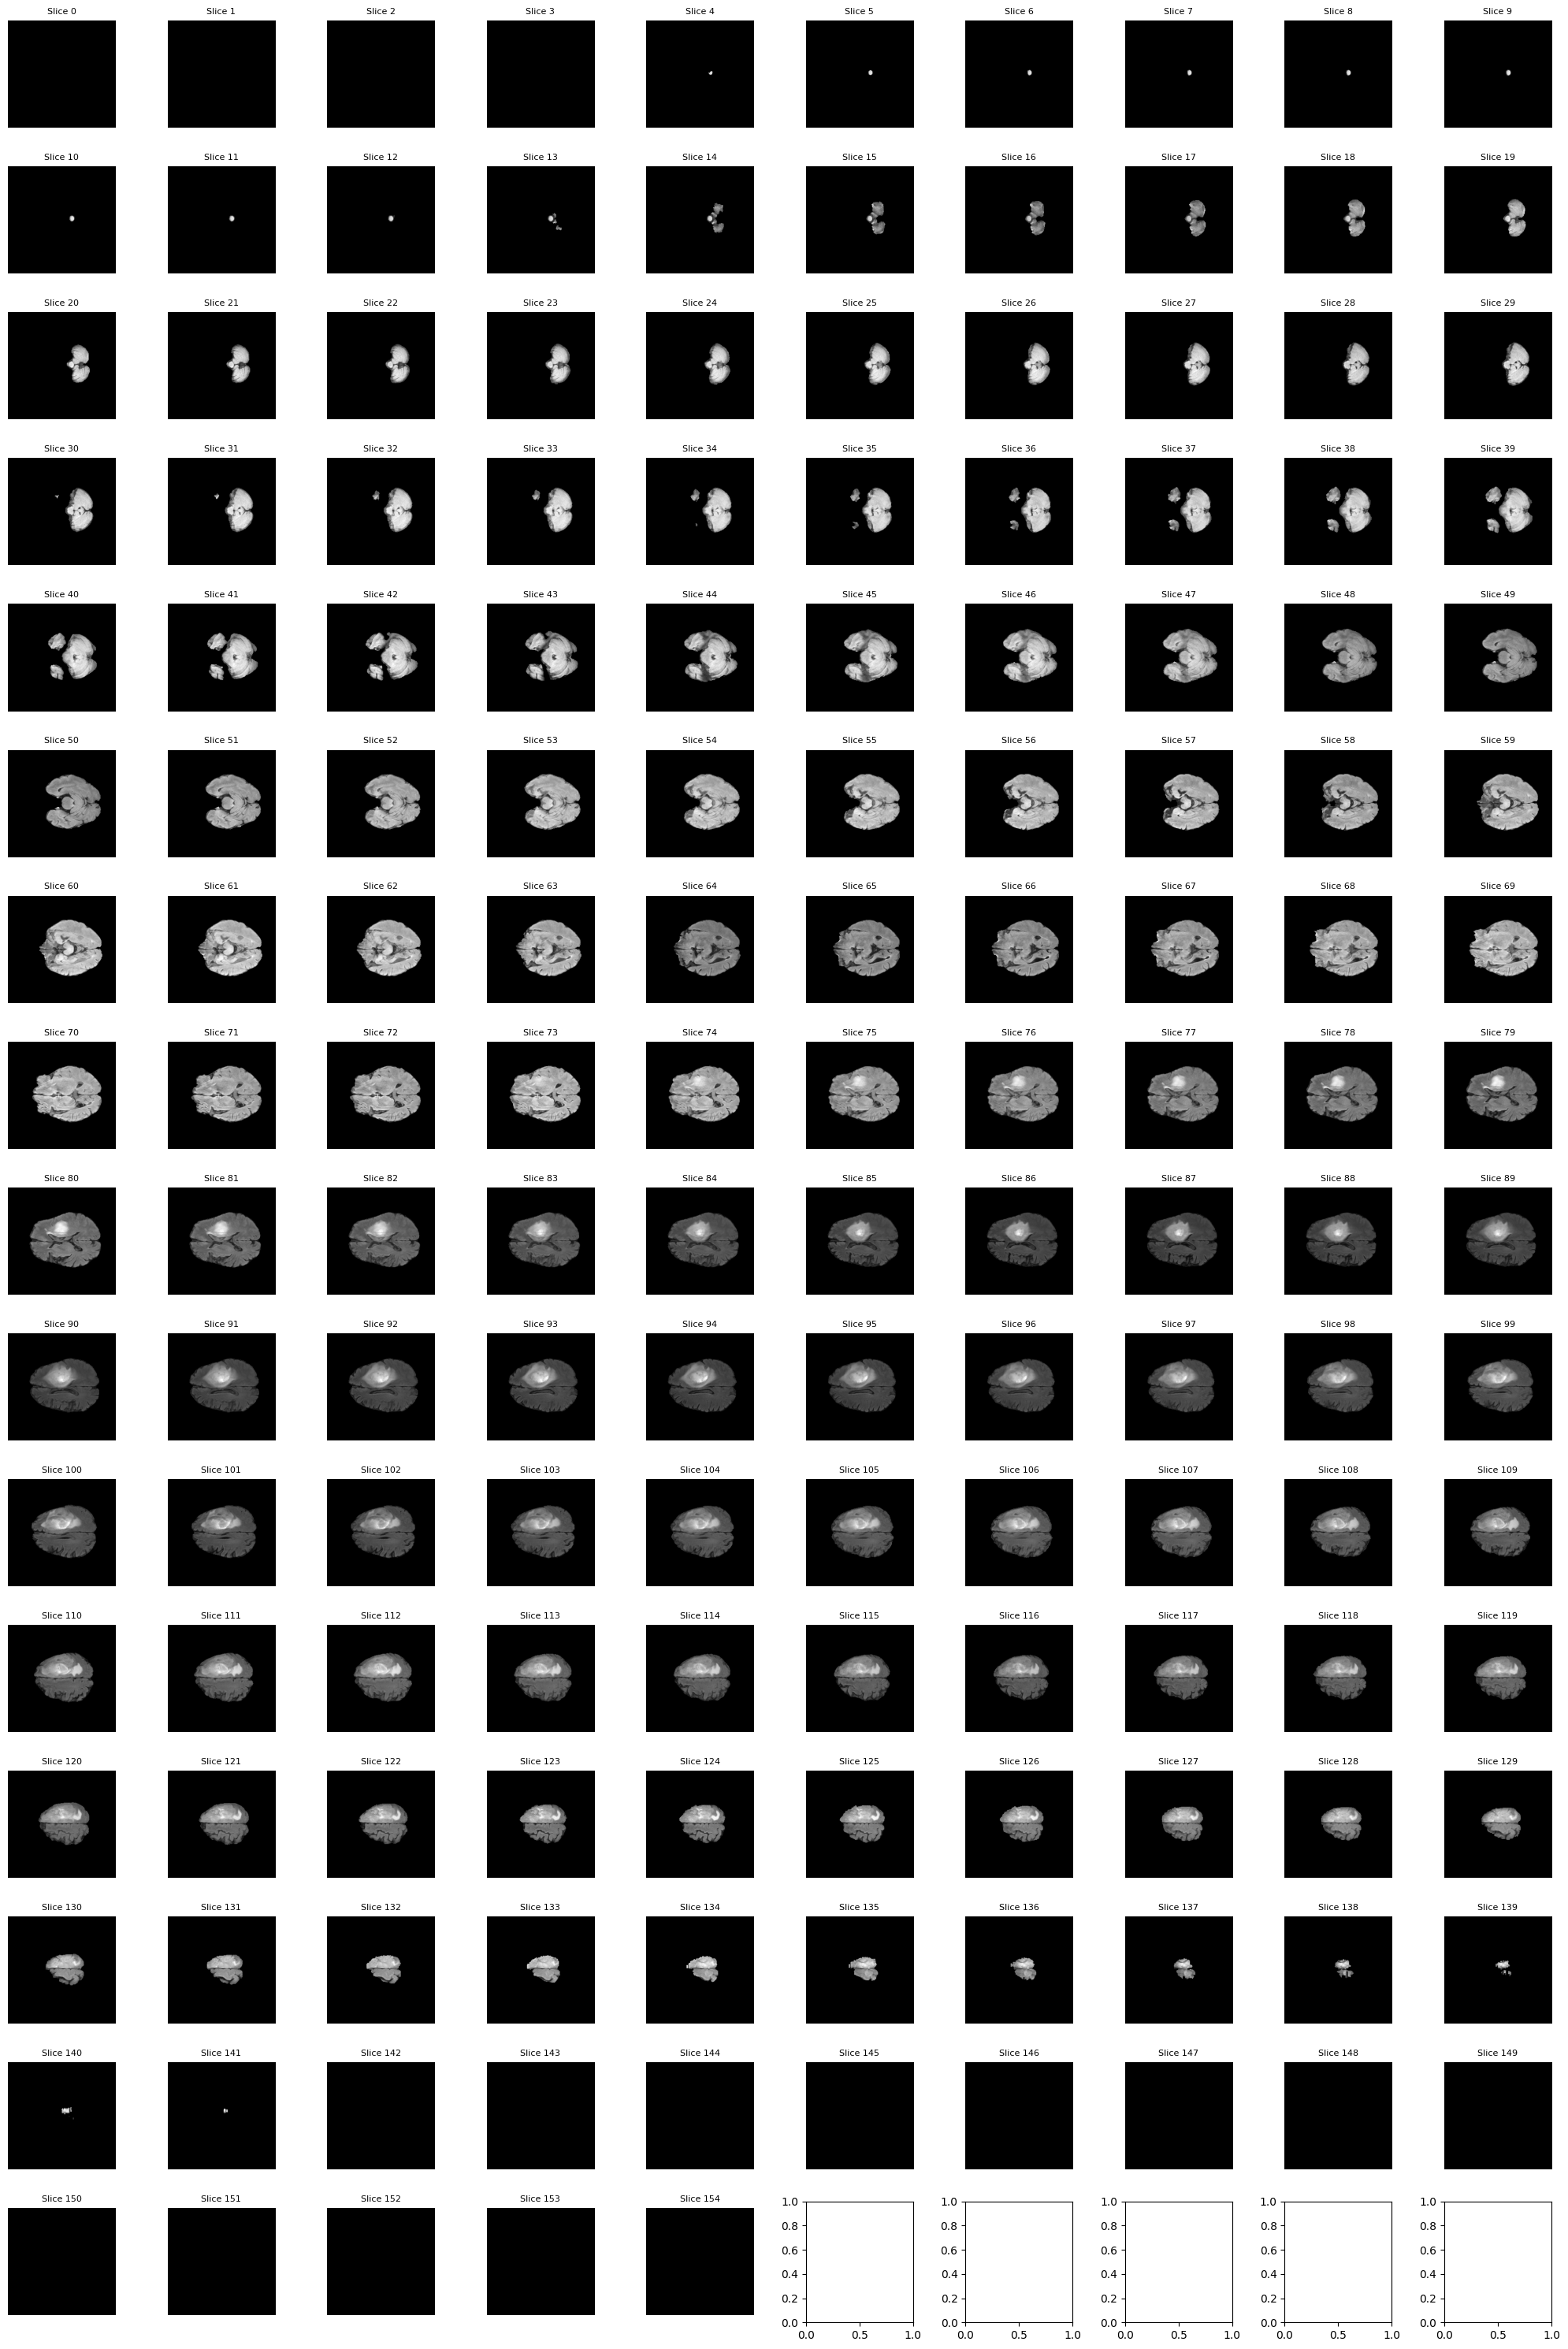

In [115]:
# Visualizing all slices of a single 3d image
import random

plt.figure(figsize=(14, 20))
fig, axes = plt.subplots(nrows=16, ncols=10, figsize=(20,30))
num_slices = test_image_flair.shape[2]

for i in range(num_slices):
    row = i // 10
    col = i % 10
    ax = axes[row, col] # select subplot index
    ax.imshow(test_image_flair[:,:,i], cmap='gray')
    ax.set_title(f'Slice {i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

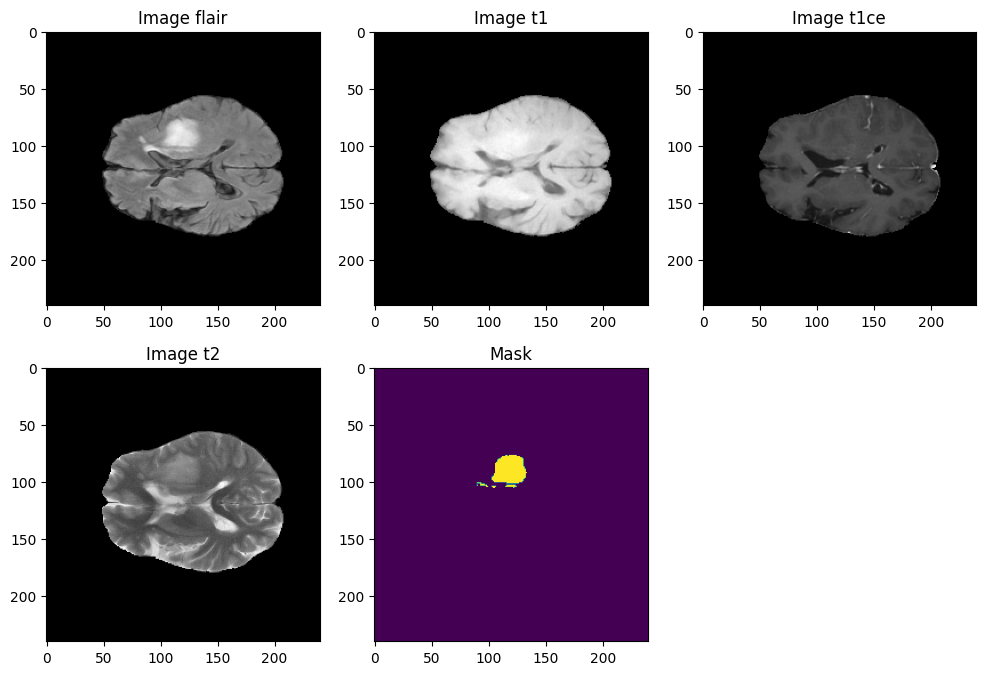

In [118]:
import random
# choose a random slice out of 155 available slices, including 0 and 155
# test_mask_shape[2] is total number of slices
slice_num = random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

# Plot number 1 within figure of 2 rows and 3 columns
plt.subplot(231)
plt.imshow(test_image_flair[:,:,slice_num], cmap='gray')
plt.title('Image flair')
# Plot number 2
plt.subplot(232)
plt.imshow(test_image_t1[:,:,slice_num], cmap='gray')
plt.title('Image t1')
# Plot number 3
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,slice_num], cmap='gray')
plt.title('Image t1ce')
# Plot number 4
plt.subplot(234)
plt.imshow(test_image_t2[:,:,slice_num], cmap='gray')
plt.title('Image t2')
# Plot number 5
plt.subplot(235)
plt.imshow(test_mask[:,:,slice_num])
plt.title('Mask')
plt.show()

In [99]:
# Combine images to channels and divide them to patches
# FLAIR, T1CE and T2 have the most information
# Hence, we'll combine t1ce, t2 and flair into single multichannel image
print("previous individual shape:", test_image_t1ce.shape)

# Order of stacking does not matter as long as we combine all 3 channels
# Creating a 4th dimension by stacking three 3D volumes
# combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2, test_image_t1], axis=3)
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
print("combined_x shape", combined_x.shape)

previous individual shape: (240, 240, 155)
combined_x shape (240, 240, 155, 3)


In [100]:
# Crop to a size to be divisible by 64 so we can later extract 64*64*64 patches
# cropping xyz, removing unuseful data within the image
combined_x = combined_x[56:184, 56:184, 13:141] # Crop to 128*128*128
print("combined_x shape", combined_x.shape)
# do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]
print("test_mask.shape", test_mask.shape)

combined_x shape (128, 128, 128, 3)
test_mask.shape (128, 128, 128)


Chose slice number 35


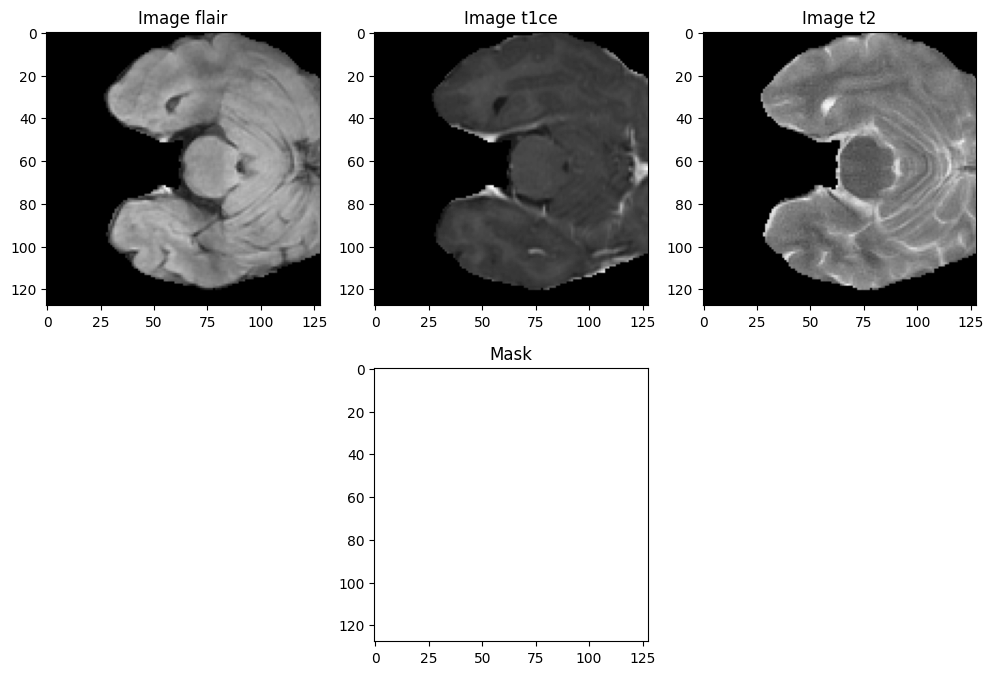

In [106]:
# Visualizing the new cropped slices
slice_num = random.randint(0, test_mask.shape[2])
print("Chose slice number", slice_num)
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(combined_x[:,:, slice_num, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(combined_x[:,:,slice_num, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(combined_x[:,:,slice_num, 2], cmap='gray')
plt.title('Image t2')
# plt.subplot(234)
# plt.imshow(combined_x[:,:,slice_num, 3], cmap='gray')
# plt.title('Image t1')
plt.subplot(235)
plt.imshow(test_mask[:,:,slice_num])
plt.title('Mask')
plt.show()

In [ ]:
# Examplifying  saving a file
imwrite('BraTS2020_TrainingData/combined255.tif', combined_x)
np.save('BraTS2020_TrainingData/combined255.npy', combined_x)

In [ ]:
# Check if can load the image back
my_image = np.load('BraTS2020_TrainingData/combined255.npy')
my_image.shape

In [104]:
# RUN ONLY ONCE
# A label array like [1,2,3] would be convert to 
# [[0,1,0,0]
# [0,0,1,0]
# [0,1,0,0]]
print(np.unique(test_mask))
print(test_mask.shape)
test_mask = to_categorical(test_mask, num_classes=4)
test_mask.shape

[0 1 2 3]
(128, 128, 128)


(128, 128, 128, 4)

In [22]:
# Getting Data ready: Training
flair_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
t1ce_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
t2_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
mask_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [23]:
# Number of patiet scans should be the same for each channel and mask
assert len(mask_list) == len(t2_list) == len(t1ce_list) == len(flair_list) == len(t1_list)

In [24]:
import os
output_base_dir = 'BraTS2020_TrainingData/input_data_3channels'
image_output_dir = os.path.join(output_base_dir, 'images')
mask_output_dir = os.path.join(output_base_dir, 'masks')

os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(mask_output_dir, exist_ok=True)

In [ ]:
# Training data processing
for image in range(len(mask_list)): # len of all lists is same
    # print("Valid: Processing image, mask number: ", image)
    temp_image_flair = nib.load(flair_list[image]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    
    temp_image_t1ce = nib.load(t1ce_list[image]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_t2 = nib.load(t2_list[image]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    # temp_image_t1=nib.load(t1_list[image]).get_fdata()
    # temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

    temp_mask = nib.load(mask_list[image]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3 # reassign mask values 4 to 3
    # print(np.unique(temp_mask))

    # temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2, temp_image_t1], axis=3)
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to a size divisible by 64 so we can later extract 64*64*64 patches
    # cropping x,y,z
    # temp_combined_images = temp_combined_images[56:184, 56:184, 56:184, 13:141]
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if(1 - (counts[0]/counts.sum())) > 0.01: # If atleast 1% volumes has labels != 0
        # print(f"Saving {image}")
        temp_mask = to_categorical(temp_mask, num_classes=4)
        np.save(os.path.join(image_output_dir, f'image_{image}.npy'), temp_combined_images)
        np.save(os.path.join(mask_output_dir, f'mask_{image}.npy'), temp_mask)
    else:
        print(f"Image {image} is USELESS.")
        

In [26]:
# Run ONLY ONCE for splitting initially
import splitfolders
input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

In [119]:
"""
Custom Data Generator
Loading from local dir in batches, all Image processing has already been performed.
"""
import os
import numpy as np

In [120]:
def load_image(image_dir, image_list):
    images = []
    for i, image_name in enumerate(image_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(image_dir + image_name)
            images.append(image)
    # images = np.array(images)
    images = np.array(images, dtype=np.float32)
    return (images)

def image_loader(image_dir, image_list, mask_dir, mask_list, batch_size):
    L = len(image_list)
    # Keras needs an infinite generator, so we will use while true
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = load_image(image_dir, image_list[batch_start:limit])
            Y = load_image(mask_dir, mask_list[batch_start:limit])

            # yeild a tuple with 2 ndarrays with batch_size samples
            # yield works iteratively
            yield (X,Y)

            batch_start += batch_size
            batch_end += batch_size

In [7]:
# Testing the generator
from matplotlib import pyplot as plt
import random

train_image_dir = 'BraTS2020_TrainingData/input_data_128/train/images/'
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"
train_image_list = os.listdir(train_image_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_image_datagen = image_loader(train_image_dir,
                                  train_image_list,
                                  train_mask_dir,
                                  train_mask_list,
                                  batch_size)

# Verify generator
image, mask = train_image_datagen.__next__()

In [8]:
print(image.shape)
# (batch_size, image_height, image_width, slices_per_volume, 3(channels merged together))
print(mask.shape)
# (..., 4) 4 represents the 4 segmentation categories

(2, 128, 128, 128, 3)
(2, 128, 128, 128, 4)


In [9]:
image_num = random.randint(0, image.shape[0]-1)
test_image = image[image_num]
test_mask = mask[image_num]
test_mask = np.argmax(test_mask, axis=3)
print(test_mask.shape)
print(test_image.shape)


(128, 128, 128)
(128, 128, 128, 3)


Chose slice_num 104


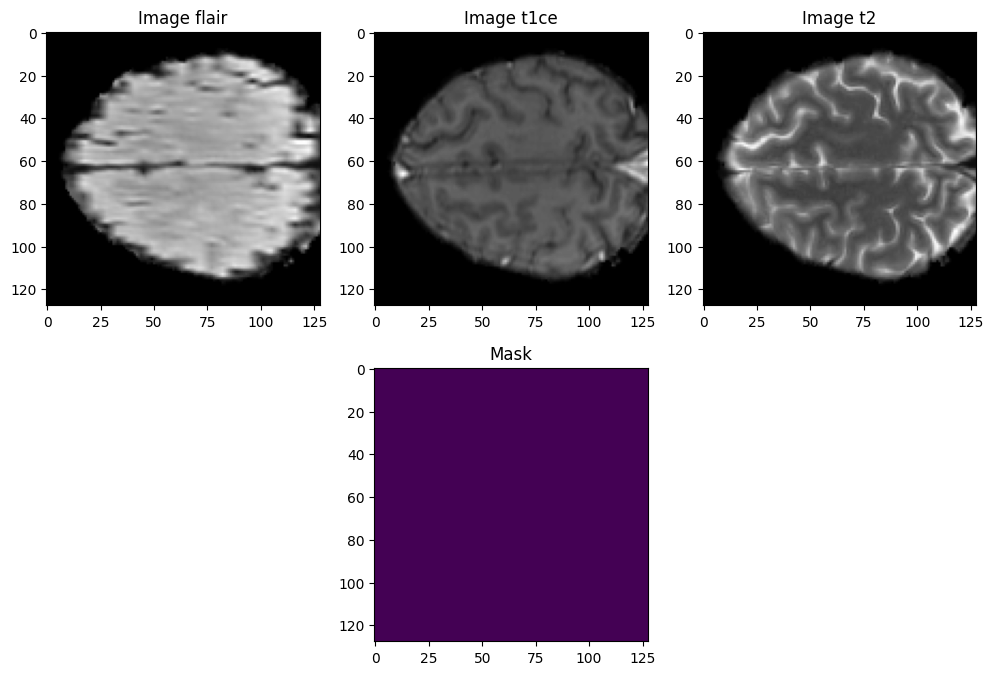

In [10]:
slice_num = random.randint(0,test_mask.shape[2])
print("Chose slice_num",slice_num)
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.imshow(test_image[:,:,slice_num,0], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image[:,:,slice_num,1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(233)
plt.imshow(test_image[:,:,slice_num,2], cmap='gray')
plt.title('Image t2')
# plt.subplot(234)
# plt.imshow(test_image[:,:,slice_num,3], cmap='gray')
# plt.title('Image t1')
plt.subplot(235)
plt.imshow(test_mask[:,:,slice_num])
plt.title('Mask')
plt.show()

In [58]:
"""Training and Prediction"""
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, Conv3DTranspose, BatchNormalization, Dropout, Lambda, concatenate
from keras.metrics import MeanIoU
from keras.optimizers import Adam

kernel_initializer = 'he_uniform'

In [59]:
def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction half of the Unet
    c1 = Conv3D(16, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3,3,3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    p1 = MaxPooling3D((2,2,2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible
    model.summary()
    
    return model

In [60]:
model = unet_model(IMG_HEIGHT=128,
                  IMG_WIDTH=128,
                  IMG_DEPTH=128,
                  IMG_CHANNELS=3,
                  num_classes=4)
print("model input shape", model.input_shape)
print("model output shape",model.output_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_58 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_3[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_12    │ (None, 64, 64,    │          0 │ conv3d_58[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_59 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_12… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 64, 64,    │          0 │ conv3d_59[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_60 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_28[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_13    │ (None, 32, 32,    │          0 │ conv3d_60[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_61 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_13… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32, 32,    │          0 │ conv3d_61[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_62 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_29[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_14    │ (None, 16, 16,    │          0 │ conv3d_62[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_63 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_14… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 16, 16,    │          0 │ conv3d_63[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_64 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_30[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_15    │ (None, 8, 8, 8,   │          0 │ conv3d_64[0][0]   │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_65 (Conv3D)  │ (None, 8, 8, 8,   │    884,992 │ max_pooling3d_15… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 8, 8, 8,   │          0 │ conv3d_65[0][0] 

 Total params: 5,638,900 (21.51 MB)

 Trainable params: 5,638,900 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

model input shape (None, 128, 128, 128, 3)
model output shape (None, 128, 128, 128, 4)


In [61]:
# Training the 3D UNET model
import os
import glob
import random
import numpy as np
import keras
# import tensorflow as tf
from matplotlib import pyplot as plt
# already have image_loader in the notebook

# Expected input image shape is 128*128*128*3 (3 is because we merged 3 channels)

In [62]:
train_image_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

image_list = os.listdir(train_image_dir)
mask_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_image_dir))
print("Number of training images =", num_images)

Number of training images = 258


In [63]:
image_num = random.randint(0,num_images-1)
test_image = np.load(train_image_dir + image_list[image_num])
test_mask = np.load(train_mask_dir + mask_list[image_num])
test_mask = np.argmax(test_mask, axis=3)

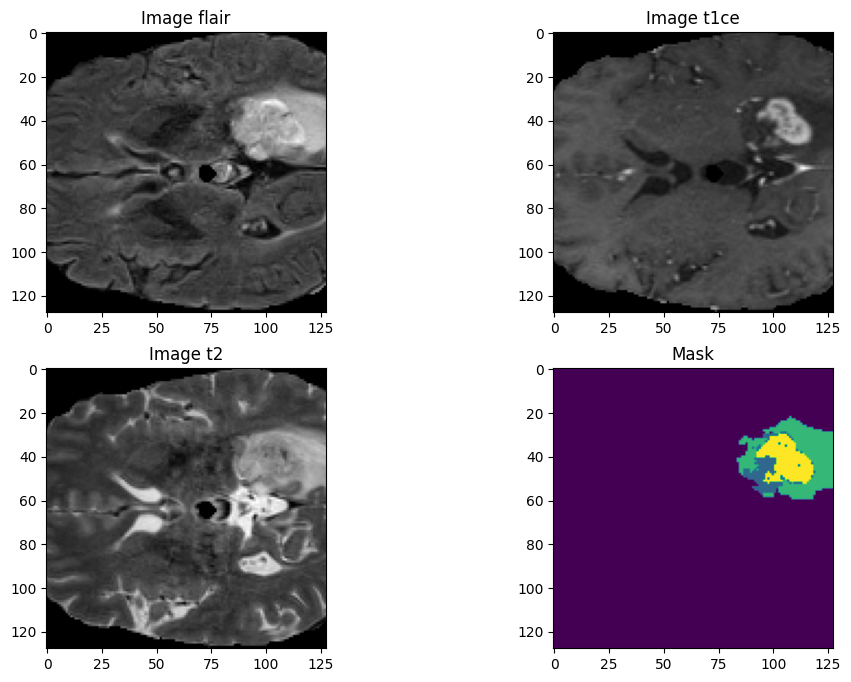

In [72]:
slice_num = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.imshow(test_image[:,:,slice_num,0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_image[:,:,slice_num, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_image[:,:,slice_num, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,slice_num])
plt.title('Mask')
plt.show()

In [73]:
# Finding the distribution of each class to find weights
# Not running right now
import pandas as pd
columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for image in range(len(train_mask_list)):
    # print(image)
    temp_image = np.load(train_mask_list[image])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)

    # df = df.append(counts_dict, ignore_index=True)
    df = pd.concat([df, pd.Series(counts_dict).to_frame().T], ignore_index=True)

label0 = df['0'].sum()
label1 = df['1'].sum()
label2 = df['2'].sum()
label3 = df['3'].sum()
labels = [label0, label1, label2, label3]
total_labels = label0 + label1 + label2 + label3
n_classes = 4

print(f"Label 0 count:", label0)
print(f"Label 1 count: {label1}")
print(f"Label 2 count: {label2}")
print(f"Label 3 count: {label3}")
for i in range(4):
    percent = (labels[i]/total_labels)*100
    print(f"Proportion of Label {i} is {percent}%")

# Class weight = n_samples / (n_classes * n_samples_for_classes)
weights = []
for i, label_count in enumerate([label0, label1, label2, label3]):
    if label_count == 0:
        weight = 0.0
        print(f"Warning: class {i} has zero occurences. Setting weight to {weight}.")
    else:
        weight = round((total_labels / (n_classes* label_count)), 2)
    weights.append(weight)
    
weight0, weight1, weight2, weight3 = weights
print(f"Weight for class 0: {weight0}")
print(f"Weight for class 1: {weight1}")
print(f"Weight for class 2: {weight2}")
print(f"Weight for class 3: {weight3}")
# weight0 = round((total_labels / (n_classes * label0)), 2) # round to 2 decimals
# weight1 = round((total_labels / (n_classes * label1)), 2)
# weight2 = round((total_labels / (n_classes * label2)), 2)
# weight3 = round((total_labels / (n_classes * label3)), 2)


Label 0 count: 515098764
Label 1 count: 5901688
Label 2 count: 14990686
Label 3 count: 5074078
Proportion of Label 0 is 95.20086465879928%
Proportion of Label 1 is 1.0907535405122033%
Proportion of Label 2 is 2.77058764021526%
Proportion of Label 3 is 0.9377941604732543%
Weight for class 0: 0.26
Weight for class 1: 22.92
Weight for class 2: 9.02
Weight for class 3: 26.66


In [74]:
train_image_dir = 'BraTS2020_TrainingData/input_data_128/train/images/'
train_mask_dir = 'BraTS2020_TrainingData/input_data_128/train/masks/'

valid_image_dir = 'BraTS2020_TrainingData/input_data_128/val/images/'
valid_mask_dir = 'BraTS2020_TrainingData/input_data_128/val/masks/'

train_image_list = os.listdir(train_image_dir)
train_mask_list = os.listdir(train_mask_dir)

valid_image_list = os.listdir(valid_image_dir)
valid_mask_list = os.listdir(valid_mask_dir)

In [75]:
batch_size = 2

train_image_datagen = image_loader(train_image_dir,
                                  train_image_list,
                                 train_mask_dir,
                                 train_mask_list,
                                 batch_size)
valid_image_datagen = image_loader(valid_image_dir,
                                 valid_image_list,
                                 valid_mask_dir,
                                 valid_mask_list,
                                 batch_size)

image, mask = train_image_datagen.__next__()

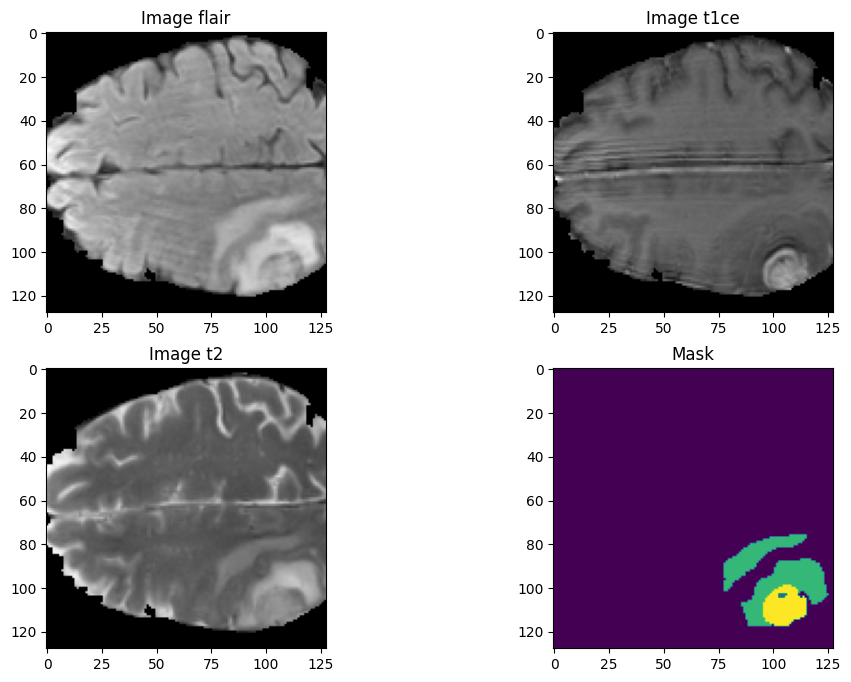

In [76]:
image_num = random.randint(0, image.shape[0]-1)
test_image = image[image_num]
test_mask = mask[image_num]
test_mask = np.argmax(test_mask, axis=3)

slice_num = random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(221)
plt.imshow(test_image[:,:,slice_num,0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_image[:,:,slice_num, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_image[:,:,slice_num, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,slice_num])
plt.title('Mask')
plt.show()

In [77]:
# Loss, metrics and optimizer for training
# wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
wt0, wt1, wt2, wt3 = 0.26, 22.92, 9.02, 26.66
max_weight = max(wt0, wt1, wt2, wt3)
scaled_weights = [wt / max_weight for wt in [wt0, wt1, wt2, wt3]]
print("Scaled weights", scaled_weights)
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights = np.array(scaled_weights))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optimizer = keras.optimizers.Adam(LR)

Scaled weights [0.009752438109527382, 0.8597149287321831, 0.33833458364591146, 1.0]


In [78]:
# Fit
steps_per_epoch = len(train_image_list)//batch_size
val_steps_per_epoch = len(valid_image_list)//batch_size

model = unet_model(IMG_HEIGHT=128,
                  IMG_WIDTH=128,
                  IMG_DEPTH=128,
                  IMG_CHANNELS=3,
                  num_classes=4)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_4[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 64, 64,    │          0 │ conv3d_77[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_16… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64, 64,    │          0 │ conv3d_78[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_79 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_37[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 32, 32,    │          0 │ conv3d_79[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_80 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_17… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 32, 32,    │          0 │ conv3d_80[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_81 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_38[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 16, 16,    │          0 │ conv3d_81[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_82 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_18… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 16, 16,    │          0 │ conv3d_82[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_83 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_39[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 8, 8, 8,   │          0 │ conv3d_83[0][0]   │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_84 (Conv3D)  │ (None, 8, 8, 8,   │    884,992 │ max_pooling3d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 8, 8, 8,   │          0 │ conv3d_84[0][0] 

 Total params: 5,638,900 (21.51 MB)

 Trainable params: 5,638,900 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)
print(model.summary())
print(model.input_shape)
print(model.output_shape)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_77 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_4[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_16    │ (None, 64, 64,    │          0 │ conv3d_77[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_78 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_16… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64, 64,    │          0 │ conv3d_78[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_79 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_37[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_17    │ (None, 32, 32,    │          0 │ conv3d_79[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_80 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_17… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 32, 32,    │          0 │ conv3d_80[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_81 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_38[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 16, 16,    │          0 │ conv3d_81[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_82 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_18… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 16, 16,    │          0 │ conv3d_82[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_83 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_39[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 8, 8, 8,   │          0 │ conv3d_83[0][0]   │
│ (MaxPooling3D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_84 (Conv3D)  │ (None, 8, 8, 8,   │    884,992 │ max_pooling3d_19… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 8, 8, 8,   │          0 │ conv3d_84[0][0] 

 Total params: 5,638,900 (21.51 MB)

 Trainable params: 5,638,900 (21.51 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [80]:
history=model.fit(train_image_datagen,
                 steps_per_epoch=steps_per_epoch,
                 epochs=20,
                 verbose=1,
                 validation_data=valid_image_datagen,
                 validation_steps=val_steps_per_epoch,)
model.save("brats_3d.keras")

Epoch 1/20


/users/PGS0365/ypatel10/Advanced-AI/final-project/myenv/lib64/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_164']
Received: inputs=Tensor(shape=(None, 128, 128, 128, 3))
  # tensors, We will use the original dict key to map with the


129/129 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7975 - iou_score: 0.1380 - loss: 1.0035 - val_accuracy: 0.9234 - val_iou_score: 0.2301 - val_loss: 0.9452
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9388 - iou_score: 0.2562 - loss: 0.9383 - val_accuracy: 0.9426 - val_iou_score: 0.3297 - val_loss: 0.8914
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 128s 997ms/step - accuracy: 0.9428 - iou_score: 0.3377 - loss: 0.8877 - val_accuracy: 0.9508 - val_iou_score: 0.3629 - val_loss: 0.8584
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 119s 932ms/step - accuracy: 0.9380 - iou_score: 0.3725 - loss: 0.8562 - val_accuracy: 0.9344 - val_iou_score: 0.3816 - val_loss: 0.8384
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 116s 907ms/step - accuracy: 0.9413 - iou_score: 0.3930 - loss: 0.8367 - val_accuracy: 0.9549 - val_iou_score: 0.4086 - val_loss: 0.8219
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 810ms/step - accuracy: 0.9503 - iou_score: 0.4267 - loss: 0.8046 - val_accuracy: 0.9578 - va

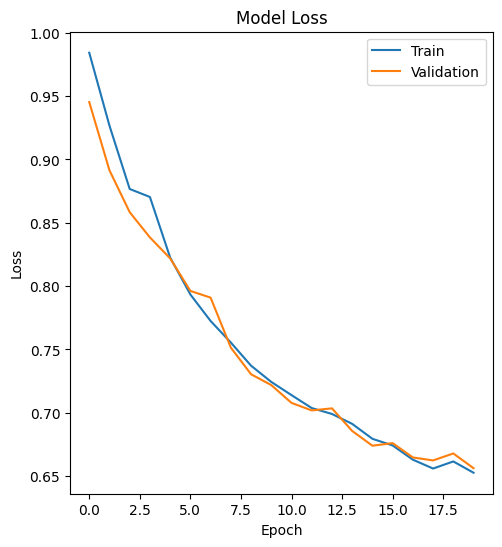

In [81]:
# Visualization of Training and Validation Loss
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

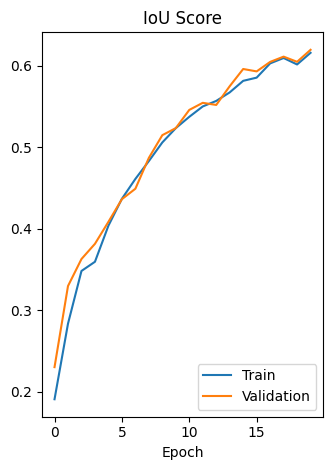

In [82]:
# Visualization of Training and Validation IoU values
plt.subplot(1,2,2)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU score')
plt.title('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

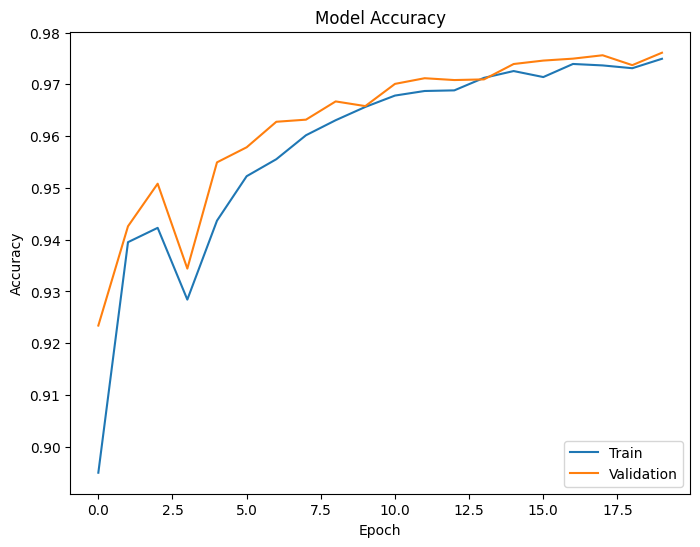

In [83]:
if 'accuracy' in history.history:
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()